# Simulate reaction with signal

### Imports

In [114]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import jax.numpy as jnp
import numpy as np
from functools import partial
import diffrax as dfx

from bioreaction.model.data_tools import construct_model
from bioreaction.model.data_containers import QuantifiedReactions
from bioreaction.misc.misc import load_json_as_dict

## Test with single species

In [115]:

def x(t, total_time, dt, step_signal):  # control signal
    return step_signal * t / (total_time / dt)

def step_function(t, total_time, num_steps):
    return jnp.floor_divide(t, total_time / num_steps)

# exponential decay subject to affine control
def fbioreaction(t, y, args, x=None):
    return -y + x(t)

t0, t1, dt0 = 0, 60, 0.1
# signal = partial(x, total_time=t1, dt=dt0, step_signal=4)
signal = partial(step_function, total_time=t1, num_steps=3)

term = dfx.ODETerm(partial(fbioreaction, x=signal))
solver = dfx.Tsit5()
saveat = dfx.SaveAt(t0=True, t1=True, steps=True)
sim_result = dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=1, saveat=saveat)


/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


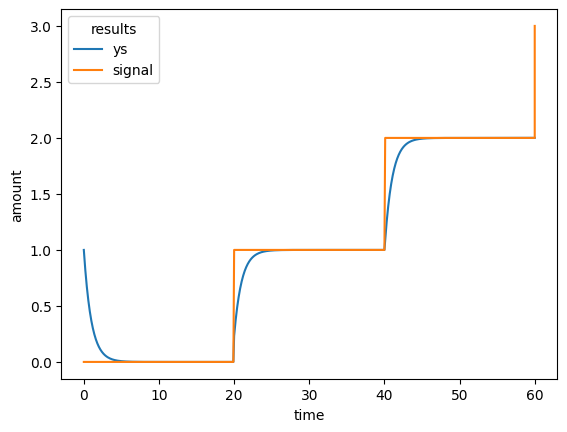

In [118]:
# plt.plot(sim_result.ts, sim_result.ys)
# plt.plot(sim_result.ts, [signal(t) for t in sim_result.ts])
# plt.show()

data = pd.DataFrame()
data['time'] = sim_result.ts
data['ys'] = sim_result.ys
data['signal'] = np.array([signal(t) for t in sim_result.ts])

dfm = data.melt('time', var_name='results', value_name='amount')
sns.lineplot(x='time', y='amount', hue='results', data=dfm)  # , kind='point')
plt.savefig('signals.png')

## Test with multiple species

In [66]:

config = load_json_as_dict('../scripts/playground_signals/simple_config.json')
model = construct_model(config)

qreactions = QuantifiedReactions()
qreactions.init_properties(model, config)


def x(t, total_time, dt, step_signal):  # control signal
    return step_signal * t / (total_time / dt)

def step_function(t, total_time, num_steps):
    return jnp.floor_divide(t, total_time / num_steps) * 100

# exponential decay subject to affine control
def fbioreaction(t, y, args, x=None):
    return -y + x(t)


signal_species = "RNA1"

t0, t1, dt0 = 0, 60, 0.1
# signal = partial(x, total_time=t1, dt=dt0, step_signal=4)
signal = partial(step_function, total_time=t1, num_steps=2)

term = dfx.ODETerm(partial(fbioreaction, x=signal))
solver = dfx.Tsit5()
saveat = dfx.SaveAt(t0=True, t1=True, steps=True)
sim_result = dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, 
    y0=qreactions.quantities, saveat=saveat)


/Users/oliviagallup/Desktop/Kode/Oxford/DPhil/env_bioreactions/lib/python3.8/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/Users/oliviagallup/Desktop/Kode/Oxford/DPhil/env_bioreactions/lib/python3.8/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


In [67]:
data = pd.DataFrame(columns=[s.name for s in model.species], data=sim_result.ys)
data.head()


,RNA1,RNA2,"(RNA1, RNA1)","(RNA2, RNA3)",RNA3,"(RNA3, RNA3)","(RNA1, RNA2)","(RNA1, RNA3)","(RNA2, RNA2)"
0,100.000000,100.000000,0.0,0.0,100.000000,0.0,0.0,0.0,0.0
1,90.483742,90.483742,0.0,0.0,90.483742,0.0,0.0,0.0,0.0
2,81.873085,81.873085,0.0,0.0,81.873085,0.0,0.0,0.0,0.0
3,74.081833,74.081833,0.0,0.0,74.081833,0.0,0.0,0.0,0.0
4,67.032005,67.032005,0.0,0.0,67.032005,0.0,0.0,0.0,0.0


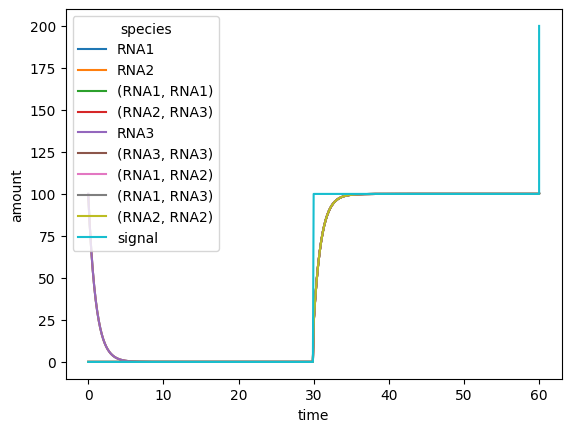

In [68]:
# plt.plot(sim_result.ts, sim_result.ys)
# plt.plot(sim_result.ts, [signal(t) for t in sim_result.ts])
# plt.show()

data = pd.DataFrame(columns=[str(s.name) for s in model.species], data=sim_result.ys)
data['time'] = sim_result.ts
data['signal'] = np.array([signal(t) for t in sim_result.ts])

dfm = data.melt('time', var_name='species', value_name='amount')
sns.lineplot(x='time', y='amount', hue='species', data=dfm)  # , kind='point')
plt.savefig('signals.png')